Hyperparameter optimization on RF models trained on reaction data
* 10-fold CV on training data
* is the ideal number of trees very different between random, AL, and merged data?
* regression performance with AL, random, and merged data
* classification performance by yield cut-off
* feature ablation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed, dump, load
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import scipy


plt.rcParams.update({"font.size":9})
custom_palette = ['#005EB8', '#C4476E', '#008C95', '#4F5199', "#B0B0B0"]

In [2]:
df_exp = pd.read_csv("../data/experimental_results_final.csv")
f_cols = [col for col in df_exp.columns if col.startswith('f_')]
target = "CAD Yield (%)"
df_exp.dropna(subset=[target], inplace=True)

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df_exp["selection"].value_counts()

active_learning_2           96
random_1                    95
random_3                    93
test_2                      91
random_4                    90
active_learning_3           86
random_2                    84
initial_diverse             83
active_learning_1           76
test_1                      70
cores2_test_1               45
cores2_active_learning_1    45
cores2_active_learning_2    44
cores2_test_2               40
test_3                      32
Name: selection, dtype: int64

In [11]:
# drop analysis batches, which shouldn't be used for comparison of AL and random sampling
df_exp = df_exp[~df_exp["selection"].isin(["cross_active_learning", "cross_random", "unexplored", "high_yield"])]

In [13]:
df_alrand = df_exp[~df_exp["selection"].str.contains("test")]

fp_cols = f_cols[:2048]
dft_cols = f_cols[2048:]
n_comp = 15
pca = sklearn.decomposition.PCA(n_components=n_comp)
pca.fit(df_alrand[fp_cols])
fp_pca_cols = ["pca_%s" % i for i in range(n_comp)]
df_exp[fp_pca_cols] = pca.transform(df_exp[fp_cols])

In [14]:
df_alrand = df_exp[~df_exp["selection"].str.contains("test")]
df_al = df_exp[df_exp["selection"].str.contains("active_learning")]
df_al = pd.concat([df_al, df_exp[df_exp["selection"] == "initial_diverse"]])
df_al1 = df_exp[df_exp["selection"].isin(["active_learning_1", "active_learning_2", "active_learning_3"])]
df_al1 = pd.concat([df_al1, df_exp[df_exp["selection"] == "initial_diverse"]])
df_rand = df_exp[df_exp["selection"].str.contains("random")]
df_test = df_exp[df_exp["selection"].str.contains("test")]
df_test1 = df_exp[df_exp["selection"].isin(["test_1", "test_2", "test_3"])]
df_test2 = df_exp[df_exp["selection"].str.contains("cores2_test")]

print(df_exp.shape, df_al.shape, df_al1.shape, df_rand.shape, df_test.shape, df_alrand.shape)

(1070, 2164) (430, 2164) (341, 2164) (362, 2164) (278, 2164) (792, 2164)


In [6]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model.fit(df_alrand[f_cols], df_alrand[target])

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [12]:
rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {'max_depth': [2, 4, 6, 8, None], "n_estimators": [25, 50, 100, 200, 300, 500]} #, 750, 1000]}
search = GridSearchCV(rf_model, param_grid, cv=5, verbose=10)
search.fit(df_alrand[f_cols], df_alrand[target])

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START max_depth=2, n_estimators=25...............................
[CV 1/5; 1/30] END max_depth=2, n_estimators=25;, score=0.298 total time=  17.7s
[CV 2/5; 1/30] START max_depth=2, n_estimators=25...............................
[CV 2/5; 1/30] END max_depth=2, n_estimators=25;, score=0.245 total time=   2.1s
[CV 3/5; 1/30] START max_depth=2, n_estimators=25...............................
[CV 3/5; 1/30] END max_depth=2, n_estimators=25;, score=0.419 total time=   0.3s
[CV 4/5; 1/30] START max_depth=2, n_estimators=25...............................
[CV 4/5; 1/30] END max_depth=2, n_estimators=25;, score=-0.123 total time=   0.2s
[CV 5/5; 1/30] START max_depth=2, n_estimators=25...............................
[CV 5/5; 1/30] END max_depth=2, n_estimators=25;, score=0.153 total time=   0.2s
[CV 1/5; 2/30] START max_depth=2, n_estimators=50...............................
[CV 1/5; 2/30] END max_depth=2, n_estimators=5

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'n_estimators': [25, 50, 100, 200, 300, 500]},
             verbose=10)

In [ ]:
search.best_estimator_

In [15]:
rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {'max_depth': [2, 4, 6, 8, None], "n_estimators": [25, 35, 50, 65, 80]} # 100, 200, 300, 500]} #, 750, 1000]}
search_small = GridSearchCV(rf_model, param_grid, cv=5, verbose=10)
search_small.fit(df_alrand[f_cols], df_alrand[target])

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START max_depth=2, n_estimators=25...............................
[CV 1/5; 1/25] END max_depth=2, n_estimators=25;, score=0.314 total time=   0.3s
[CV 2/5; 1/25] START max_depth=2, n_estimators=25...............................
[CV 2/5; 1/25] END max_depth=2, n_estimators=25;, score=0.297 total time=   0.2s
[CV 3/5; 1/25] START max_depth=2, n_estimators=25...............................
[CV 3/5; 1/25] END max_depth=2, n_estimators=25;, score=0.448 total time=   0.3s
[CV 4/5; 1/25] START max_depth=2, n_estimators=25...............................
[CV 4/5; 1/25] END max_depth=2, n_estimators=25;, score=-0.116 total time=   0.3s
[CV 5/5; 1/25] START max_depth=2, n_estimators=25...............................
[CV 5/5; 1/25] END max_depth=2, n_estimators=25;, score=0.138 total time=   0.3s
[CV 1/5; 2/25] START max_depth=2, n_estimators=35...............................
[CV 1/5; 2/25] END max_depth=2, n_estimators=3

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'n_estimators': [25, 35, 50, 65, 80]},
             verbose=10)

In [16]:
rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {'max_depth': [2, 4, 6, 8, None], "n_estimators": [600, 750, 1000]}
search_large = GridSearchCV(rf_model, param_grid, cv=5, verbose=10)
search_large.fit(df_alrand[f_cols], df_alrand[target])

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=2, n_estimators=600..............................
[CV 1/5; 1/15] END max_depth=2, n_estimators=600;, score=0.310 total time=   1.0s
[CV 2/5; 1/15] START max_depth=2, n_estimators=600..............................
[CV 2/5; 1/15] END max_depth=2, n_estimators=600;, score=0.259 total time=   1.1s
[CV 3/5; 1/15] START max_depth=2, n_estimators=600..............................
[CV 3/5; 1/15] END max_depth=2, n_estimators=600;, score=0.439 total time=   1.0s
[CV 4/5; 1/15] START max_depth=2, n_estimators=600..............................
[CV 4/5; 1/15] END max_depth=2, n_estimators=600;, score=-0.167 total time=   1.1s
[CV 5/5; 1/15] START max_depth=2, n_estimators=600..............................
[CV 5/5; 1/15] END max_depth=2, n_estimators=600;, score=0.136 total time=   1.0s
[CV 1/5; 2/15] START max_depth=2, n_estimators=750..............................
[CV 1/5; 2/15] END max_depth=2, n_estimato

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'n_estimators': [600, 750, 1000]},
             verbose=10)

In [17]:
print(search.best_score_)
print(search_small.best_score_)
print(search_large.best_score_)

0.25115884948919726
0.2662625344839495
0.24742603903606103


In [19]:
search_large.best_estimator_

RandomForestRegressor(max_depth=6, n_estimators=1000, n_jobs=-1)

In [18]:
search_small.best_estimator_

RandomForestRegressor(max_depth=6, n_estimators=80, n_jobs=-1)

# PCA to reduce dimensionality of reaction fingerprints

In [15]:
def score_model(y_val, y_pred):
    performance = {}
    performance["r2"] = sklearn.metrics.r2_score(y_val, y_pred)
    performance["mae"] = sklearn.metrics.mean_absolute_error(y_val, y_pred)
    performance["rmse"] = sklearn.metrics.mean_squared_error(y_val, y_pred, squared=False)
    performance["spearmanr"] = scipy.stats.spearmanr(y_val, y_pred)
    performance["mean"] = np.mean(y_pred)

    for threshold in [10, 20, 30, 40, 50]:
        performance[f"{threshold}_acc"] = sklearn.metrics.accuracy_score(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_recall"] = sklearn.metrics.recall_score(y_val > threshold, y_pred > threshold, zero_division=0)
        performance[f"{threshold}_f1"] = sklearn.metrics.f1_score(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_precision"] = sklearn.metrics.precision_score(y_val > threshold, y_pred > threshold, zero_division=0)
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_val > threshold, y_pred > threshold)
        performance[f"{threshold}_prc-auc"] = sklearn.metrics.auc(recall, precision)

    return performance

In [16]:
# PCA transform on training data
n_comp = 15
for i in np.arange(10):
    pca = sklearn.decomposition.PCA(n_components=n_comp)
    pca.fit(df_alrand[fp_cols])
    df_alrandpca = df_alrand.copy()
    df_testpca = df_test.copy()
    fp_pca_cols = ["pca_%s" % i for i in range(n_comp)]
    #df_alrandpca[fp_pca_cols] = pca.transform(df_alrandpca[fp_cols])
    #df_testpca[fp_pca_cols] = pca.transform(df_testpca[fp_cols])
    df_alrandpca.loc[:, fp_pca_cols] = pca.transform(df_alrandpca[fp_cols])
    df_testpca.loc[:, fp_pca_cols] = pca.transform(df_testpca[fp_cols])

    fpca_cols = fp_pca_cols + dft_cols
    rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=80)
    rf_model.fit(df_alrandpca[fpca_cols], df_alrandpca[target])
    y_pred = rf_model.predict(df_testpca[fpca_cols])
    score_pca = score_model(df_test[target], y_pred)
    print(n_comp, score_pca["r2"], score_pca["rmse"], score_pca["20_f1"], score_pca["30_f1"])

15 0.49477843942408495 16.89732203946643 0.6666666666666666 0.5301204819277109
15 0.5076821026850544 16.680142449454557 0.6717557251908397 0.5128205128205129
15 0.5233865530793038 16.411946356170496 0.6885245901639344 0.5
15 0.49349184199304563 16.918823722700616 0.6615384615384615 0.5476190476190477
15 0.5056814018434106 16.714000795200057 0.7049180327868853 0.5
15 0.5294831911099459 16.306641172368668 0.6825396825396826 0.49350649350649345
15 0.5272858567055019 16.344673190706693 0.6771653543307086 0.5609756097560975
15 0.5185754774597167 16.494571863044868 0.6885245901639344 0.5454545454545455
15 0.4854669400764998 17.052324377152164 0.6771653543307086 0.5185185185185185
15 0.5576381147180316 15.811234991792244 0.7244094488188977 0.5925925925925927


In [17]:
score_pca

{'r2': 0.5576381147180316,
 'mae': 9.188821933416941,
 'rmse': 15.811234991792244,
 'spearmanr': SpearmanrResult(correlation=0.6700162074257585, pvalue=1.3821159361394086e-37),
 'mean': 12.638731466667448,
 '10_acc': 0.8345323741007195,
 '10_recall': 0.9436619718309859,
 '10_f1': 0.7444444444444445,
 '10_precision': 0.6146788990825688,
 '10_prc-auc': 0.786364680061094,
 '20_acc': 0.8741007194244604,
 '20_recall': 0.8070175438596491,
 '20_f1': 0.7244094488188977,
 '20_precision': 0.6571428571428571,
 '20_prc-auc': 0.7518643731631235,
 '30_acc': 0.8812949640287769,
 '30_recall': 0.631578947368421,
 '30_f1': 0.5925925925925927,
 '30_precision': 0.5581395348837209,
 '30_prc-auc': 0.6200390972411789,
 '40_acc': 0.9172661870503597,
 '40_recall': 0.4642857142857143,
 '40_f1': 0.5306122448979592,
 '40_precision': 0.6190476190476191,
 '40_prc-auc': 0.5686450839328537,
 '50_acc': 0.9532374100719424,
 '50_recall': 0.3888888888888889,
 '50_f1': 0.5185185185185185,
 '50_precision': 0.77777777777777

In [46]:
len(dft_cols)

87

In [71]:
rf_model = RandomForestRegressor(n_jobs=-1)
param_grid = {'max_depth': [2, 4, 6, 8, None], "n_estimators": [20,40,60,80,100,120,140]}
search_large = GridSearchCV(rf_model, param_grid, cv=5, verbose=10)
search_large.fit(df_alrandpca[fpca_cols], df_alrandpca[target])

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5; 1/35] START max_depth=2, n_estimators=20...............................
[CV 1/5; 1/35] END max_depth=2, n_estimators=20;, score=0.319 total time=  17.0s
[CV 2/5; 1/35] START max_depth=2, n_estimators=20...............................
[CV 2/5; 1/35] END max_depth=2, n_estimators=20;, score=0.293 total time=   2.4s
[CV 3/5; 1/35] START max_depth=2, n_estimators=20...............................
[CV 3/5; 1/35] END max_depth=2, n_estimators=20;, score=0.420 total time=   1.4s
[CV 4/5; 1/35] START max_depth=2, n_estimators=20...............................
[CV 4/5; 1/35] END max_depth=2, n_estimators=20;, score=-0.116 total time=   0.1s
[CV 5/5; 1/35] START max_depth=2, n_estimators=20...............................
[CV 5/5; 1/35] END max_depth=2, n_estimators=20;, score=0.107 total time=   0.3s
[CV 1/5; 2/35] START max_depth=2, n_estimators=40...............................
[CV 1/5; 2/35] END max_depth=2, n_estimators=4

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [2, 4, 6, 8, None],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140]},
             verbose=10)

In [72]:
search_large.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=80, n_jobs=-1)

In [61]:
rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=80)
rf_model.fit(df_alrand[f_cols], df_alrand[target])
y_pred = rf_model.predict(df_test[f_cols])
score_ex = score_model(df_test[target], y_pred)
score_ex

{'r2': 0.46776722737789456,
 'mae': 10.45543084507754,
 'rmse': 17.24164128919766,
 'spearmanr': SpearmanrResult(correlation=0.5732228116462106, pvalue=4.9585898163503515e-26),
 'mean': 12.607747988963366,
 '10_acc': 0.7730496453900709,
 '10_recall': 0.9154929577464789,
 '10_f1': 0.6701030927835052,
 '10_precision': 0.5284552845528455,
 '10_prc-auc': 0.7326124190220026,
 '20_acc': 0.8794326241134752,
 '20_recall': 0.7017543859649122,
 '20_f1': 0.7017543859649122,
 '20_precision': 0.7017543859649122,
 '20_prc-auc': 0.7318962299365435,
 '30_acc': 0.8652482269503546,
 '30_recall': 0.47368421052631576,
 '30_f1': 0.4864864864864865,
 '30_precision': 0.5,
 '30_prc-auc': 0.5223030981709593,
 '40_acc': 0.9148936170212766,
 '40_recall': 0.42857142857142855,
 '40_f1': 0.5,
 '40_precision': 0.6,
 '40_prc-auc': 0.5426545086119554,
 '50_acc': 0.950354609929078,
 '50_recall': 0.3888888888888889,
 '50_f1': 0.5,
 '50_precision': 0.7,
 '50_prc-auc': 0.5639479905437352}

In [18]:
def fit_and_score(train, test, feature_cols):
    rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=80, max_depth=6)
    rf_model.fit(train[feature_cols], train[target])
    y_pred = rf_model.predict(test[feature_cols])
    return score_model(test[target], y_pred)

def replicate_score(train, test, feature_cols, repeat=50):
    scores = {}
    for i in range(repeat):
        scores[i] = (fit_and_score(train, test, feature_cols))
    return pd.DataFrame.from_dict(scores, orient="index").drop(columns="spearmanr").mean()

In [19]:
print(len(fpca_cols), len(fp_pca_cols), len(dft_cols))

102 15 87


In [20]:
def calc_replicate_scores(df_test, features):
    scores = {}
    scores["AL+Random"] = replicate_score(df_alrand, df_test, features)
    scores["AL cores 1"] = replicate_score(df_al1, df_test, features)
    scores["AL cores 1&2"] = replicate_score(df_al, df_test, features)
    scores["Random"] = replicate_score(df_rand, df_test, features)
    return scores

# all features
print("DFT+fp")
scores_core1 = calc_replicate_scores(df_test1, f_cols)
scores_core2 = calc_replicate_scores(df_test2, f_cols)

# DFT+pca
print("DFT+pca")
scores_dftpca_core1 = calc_replicate_scores(df_test1, dft_cols+fp_pca_cols)
scores_dftpca_core2 = calc_replicate_scores(df_test2, dft_cols+fp_pca_cols)

# DFT features
print("DFT")
scores_dft_core1 = calc_replicate_scores(df_test1, dft_cols)
scores_dft_core2 = calc_replicate_scores(df_test2, dft_cols)

# fp features only
print("fp")
scores_fp_core1 = calc_replicate_scores(df_test1, fp_cols)
scores_fp_core2 = calc_replicate_scores(df_test2, fp_cols)

# pca features only
print("pca")
scores_pca_core1 = calc_replicate_scores(df_test1, fp_pca_cols)
scores_pca_core2 = calc_replicate_scores(df_test2, fp_pca_cols)

DFT+fp
DFT+pca
DFT
fp
pca


In [21]:
dfd1, dfd1Tf1 = {}, {}
dfd2, dfd2Tf1 = {}, {}

score_set1 = [scores_dftpca_core1, scores_dft_core1, scores_fp_core1, scores_pca_core1]
score_set2 = [scores_dftpca_core2, scores_dft_core2, scores_fp_core2, scores_pca_core2]

for i, test_name in enumerate(["DFT+PCA", "DFT", "DRFP", "PCA"]):
    dfd1[test_name] = pd.DataFrame.from_dict(score_set1[i], orient="index")
    dfd1Tf1[test_name] = dfd1[test_name][["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]].T
    dfd1Tf1[test_name]["Threshold"] = [10,20,30,40,50]
    dfd1Tf1[test_name]["features"] = test_name
    dfd1[test_name]["features"] = test_name

    dfd2[test_name] = pd.DataFrame.from_dict(score_set2[i], orient="index")
    dfd2Tf1[test_name] = dfd2[test_name][["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]].T
    dfd2Tf1[test_name]["Threshold"] = [10,20,30,40,50]
    dfd2Tf1[test_name]["features"] = test_name
    dfd2[test_name]["features"] = test_name

In [22]:
dfd2Tf1

{'DFT+PCA':        AL+Random  AL cores 1  AL cores 1&2    Random  Threshold features
 10_f1   0.566787    0.557113      0.624886  0.514751         10  DFT+PCA
 20_f1   0.615548    0.547261      0.629944  0.363751         20  DFT+PCA
 30_f1   0.638817    0.602066      0.800054  0.374118         30  DFT+PCA
 40_f1   0.718182    0.292393      0.865934  0.323846         40  DFT+PCA
 50_f1   0.534243    0.003077      0.540678  0.016503         50  DFT+PCA,
 'DFT':        AL+Random  AL cores 1  AL cores 1&2    Random  Threshold features
 10_f1   0.542324    0.539526      0.561982  0.495778         10      DFT
 20_f1   0.617315    0.580568      0.618200  0.274003         20      DFT
 30_f1   0.639500    0.625789      0.754987  0.375000         30      DFT
 40_f1   0.727028    0.417767      0.867473  0.386725         40      DFT
 50_f1   0.670836    0.006667      0.660199  0.298132         50      DFT,
 'DRFP':        AL+Random  AL cores 1  AL cores 1&2    Random  Threshold features
 10_f1   0

In [23]:
scores_test = {}
scores_test["AL+Random"] = replicate_score(df_alrand, df_test, f_cols)
scores_test["AL cores 1"] = replicate_score(df_al1, df_test, f_cols)
scores_test["AL cores 1&2"] = replicate_score(df_al, df_test, f_cols)
scores_test["Random"] = replicate_score(df_rand, df_test, f_cols)

In [45]:
df_core1 = pd.DataFrame.from_dict(scores_core1, orient="index")
df_core2 = pd.DataFrame.from_dict(scores_core2, orient="index")
df_coref = pd.DataFrame.from_dict(scores_test, orient="index")
df_core1

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,0.892746,...,0.910984,0.240000,0.319293,0.508395,0.407669,0.959585,0.0250,0.042667,0.160000,0.532707
AL cores 1,0.364073,8.272119,13.425702,11.467187,0.824456,0.8400,0.712662,0.618933,0.750192,0.855544,...,0.906321,0.168235,0.236153,0.435029,0.338264,0.958446,0.0000,0.000000,0.000000,0.510725
AL cores 1&2,0.422178,8.431127,12.798881,11.953000,0.834715,0.8352,0.723876,0.639126,0.758510,0.865803,...,0.899793,0.197647,0.256330,0.382981,0.325651,0.958860,0.0325,0.053939,0.183333,0.467968
Random,0.165672,8.527050,15.380590,5.987977,0.830984,0.5872,0.642551,0.712448,0.703295,0.809326,...,0.914197,0.051765,0.095205,0.660000,0.457644,0.958549,0.0000,0.000000,0.000000,0.520725


In [46]:
df_core2

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.441348,15.301535,25.588055,12.955560,0.707529,0.735238,0.553846,0.445703,0.623176,0.848000,...,0.924000,0.460000,0.607544,0.919119,0.724501,0.917882,0.302,0.462271,1.0,0.692059
AL cores 1,0.286520,16.302858,28.920136,10.121202,0.721176,0.619048,0.523219,0.453174,0.583169,0.814118,...,0.869412,0.012727,0.022051,0.090000,0.475246,0.882353,0.000,0.000000,0.0,0.558824
AL cores 1&2,0.512679,14.322255,23.893281,12.948606,0.745647,0.778095,0.600954,0.491064,0.661991,0.859294,...,0.955529,0.698182,0.797264,0.947651,0.842446,0.914824,0.276,0.422639,1.0,0.680588
Random,-0.002315,16.369218,34.278834,4.701265,0.765176,0.269524,0.360475,0.580991,0.515493,0.802824,...,0.870588,0.000000,0.000000,0.000000,0.564706,0.882353,0.000,0.000000,0.0,0.558824


In [47]:
df_coref

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.482483,10.149650,17.099929,11.884249,0.799784,0.891831,0.694884,0.569727,0.744592,0.880432,...,0.915108,0.322857,0.431814,0.674703,0.532881,0.946331,0.173333,0.293283,0.991000,0.608929
AL cores 1,0.323237,10.755314,19.554863,11.121164,0.791583,0.774648,0.655028,0.567446,0.699824,0.845612,...,0.893381,0.102857,0.158659,0.396786,0.295002,0.935468,0.003333,0.006105,0.040000,0.533933
AL cores 1&2,0.490612,10.257816,16.963029,12.305656,0.804173,0.818873,0.681204,0.583539,0.724335,0.863957,...,0.916835,0.402857,0.490082,0.645559,0.554280,0.946691,0.194444,0.310919,0.927476,0.597039
Random,0.074880,10.912403,22.864405,5.620776,0.812374,0.500000,0.576423,0.683173,0.655436,0.806691,...,0.900576,0.030000,0.056828,0.600000,0.443849,0.935252,0.000000,0.000000,0.000000,0.532374


In [48]:
df_core1

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,0.892746,...,0.910984,0.240000,0.319293,0.508395,0.407669,0.959585,0.0250,0.042667,0.160000,0.532707
AL cores 1,0.364073,8.272119,13.425702,11.467187,0.824456,0.8400,0.712662,0.618933,0.750192,0.855544,...,0.906321,0.168235,0.236153,0.435029,0.338264,0.958446,0.0000,0.000000,0.000000,0.510725
AL cores 1&2,0.422178,8.431127,12.798881,11.953000,0.834715,0.8352,0.723876,0.639126,0.758510,0.865803,...,0.899793,0.197647,0.256330,0.382981,0.325651,0.958860,0.0325,0.053939,0.183333,0.467968
Random,0.165672,8.527050,15.380590,5.987977,0.830984,0.5872,0.642551,0.712448,0.703295,0.809326,...,0.914197,0.051765,0.095205,0.660000,0.457644,0.958549,0.0000,0.000000,0.000000,0.520725


In [49]:
df_core1.to_csv("figure_data/hyperopt_pred_core1.csv")
df_core2.to_csv("figure_data/hyperopt_pred_core2.csv")
df_coref.to_csv("figure_data/hyperopt_pred_allcore.csv")

In [3]:
df_core1 = pd.read_csv("figure_data/hyperopt_pred_core1.csv", index_col=0)
df_core2 = pd.read_csv("figure_data/hyperopt_pred_core2.csv", index_col=0)

In [4]:
df_core1

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,0.892746,...,0.910984,0.240000,0.319293,0.508395,0.407669,0.959585,0.0250,0.042667,0.160000,0.532707
AL cores 1,0.364073,8.272119,13.425702,11.467187,0.824456,0.8400,0.712662,0.618933,0.750192,0.855544,...,0.906321,0.168235,0.236153,0.435029,0.338264,0.958446,0.0000,0.000000,0.000000,0.510725
AL cores 1&2,0.422178,8.431127,12.798881,11.953000,0.834715,0.8352,0.723876,0.639126,0.758510,0.865803,...,0.899793,0.197647,0.256330,0.382981,0.325651,0.958860,0.0325,0.053939,0.183333,0.467968
Random,0.165672,8.527050,15.380590,5.987977,0.830984,0.5872,0.642551,0.712448,0.703295,0.809326,...,0.914197,0.051765,0.095205,0.660000,0.457644,0.958549,0.0000,0.000000,0.000000,0.520725


In [5]:
df_core1.index = ["AL+Random", "AL Base set", "AL Base & Expanded", "Random"]
df_core2.index = ["AL+Random", "AL Base set", "AL Base & Expanded", "Random"]

In [6]:
df_core1T = df_core1[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]].T
df_core1T["Threshold"] = [10,20,30,40,50]
df_core2T = df_core2[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]].T
df_core2T["Threshold"] = [10,20,30,40,50]
df_core2T

,AL+Random,AL Base set,AL Base & Expanded,Random,Threshold
10_f1,0.553846,0.523219,0.600954,0.360475,10
20_f1,0.622293,0.562175,0.660131,0.094192,20
30_f1,0.667072,0.604748,0.793390,0.000000,30
40_f1,0.607544,0.022051,0.797264,0.000000,40
50_f1,0.462271,0.000000,0.422639,0.000000,50


In [7]:
df_core1Tprc = df_core1[["10_prc-auc", "20_prc-auc", "30_prc-auc", "40_prc-auc", "50_prc-auc"]].T
df_core1Tprc["Threshold"] = [10,20,30,40,50]
df_core2Tprc = df_core2[["10_prc-auc", "20_prc-auc", "30_prc-auc", "40_prc-auc", "50_prc-auc"]].T
df_core2Tprc["Threshold"] = [10,20,30,40,50]
df_core2Tprc

,AL+Random,AL Base set,AL Base & Expanded,Random,Threshold
10_prc-auc,0.623176,0.583169,0.661991,0.515493,10
20_prc-auc,0.660259,0.604922,0.693561,0.437118,20
30_prc-auc,0.697193,0.637150,0.807674,0.570588,30
40_prc-auc,0.724501,0.475246,0.842446,0.564706,40
50_prc-auc,0.692059,0.558824,0.680588,0.558824,50


In [8]:
sns.set_palette(palette=custom_palette)

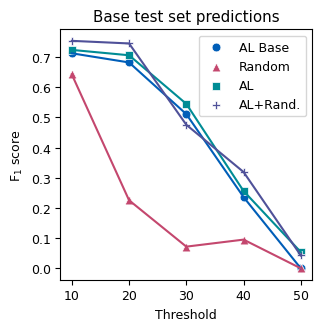

In [9]:
# plot f1 and prc-auc by yield threshold for both test sets
plt.figure(figsize=(3.25, 3.25))
scattersize = 40
sns.lineplot(data=df_core1T, x="Threshold", y="AL Base set", legend=False, color=custom_palette[0])
sns.lineplot(data=df_core1T, x="Threshold", y="Random", legend=False, color=custom_palette[1])
sns.lineplot(data=df_core1T, x="Threshold", y="AL Base & Expanded", legend=False, color=custom_palette[2])
sns.lineplot(data=df_core1T, x="Threshold", y="AL+Random", legend=False, color=custom_palette[3])
sns.scatterplot(data=df_core1T, x="Threshold", y="AL Base set", label="AL Base", marker="o", legend=False, s=scattersize, color=custom_palette[0])
sns.scatterplot(data=df_core1T, x="Threshold", y="Random", label="Random", marker="^", legend=False, s=scattersize, color=custom_palette[1])
sns.scatterplot(data=df_core1T, x="Threshold", y="AL Base & Expanded", label="AL", marker="s", legend=False, s=scattersize, color=custom_palette[2])
sns.scatterplot(data=df_core1T, x="Threshold", y="AL+Random", label="AL+Rand.", marker="P", legend=False, s=scattersize, color=custom_palette[3])
plt.title(f"Base test set predictions")
plt.legend(loc=1)
plt.ylabel(f"F$_1$ score")

plt.show()
#plt.savefig("images/baseset_traindiff_f1.png", dpi=300, bbox_inches="tight")

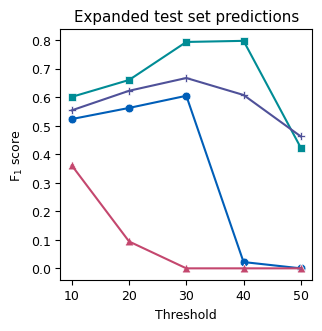

In [10]:
plt.figure(figsize=(3.25, 3.25))
scattersize = 40
sns.lineplot(data=df_core2T, x="Threshold", y="AL Base set", legend=False)
sns.lineplot(data=df_core2T, x="Threshold", y="Random", legend=False)
sns.lineplot(data=df_core2T, x="Threshold", y="AL Base & Expanded", legend=False)
sns.lineplot(data=df_core2T, x="Threshold", y="AL+Random", legend=False)
sns.scatterplot(data=df_core2T, x="Threshold", y="AL Base set", label="AL Base set", marker="o", legend=False, s=scattersize)
sns.scatterplot(data=df_core2T, x="Threshold", y="Random", label="Random", marker="^", legend=False, s=scattersize)
sns.scatterplot(data=df_core2T, x="Threshold", y="AL Base & Expanded", label="AL Base & Expanded", marker="s", legend=False, s=scattersize)
sns.scatterplot(data=df_core2T, x="Threshold", y="AL+Random", label="AL+Random", marker="P", legend=False, s=scattersize)

plt.ylabel(f"F$_1$ score")
plt.title("Expanded test set predictions")
#plt.savefig("images/expandedset_traindiff_f1.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
df_core2T

,AL+Random,AL Base set,AL Base & Expanded,Random,Threshold
10_f1,0.553846,0.523219,0.600954,0.360475,10
20_f1,0.622293,0.562175,0.660131,0.094192,20
30_f1,0.667072,0.604748,0.793390,0.000000,30
40_f1,0.607544,0.022051,0.797264,0.000000,40
50_f1,0.462271,0.000000,0.422639,0.000000,50


In [12]:
df_core1T.to_csv("figure_data/hyperopt_f1_core1T.csv")
df_core2T.to_csv("figure_data/hyperopt_f1_core2T.csv")

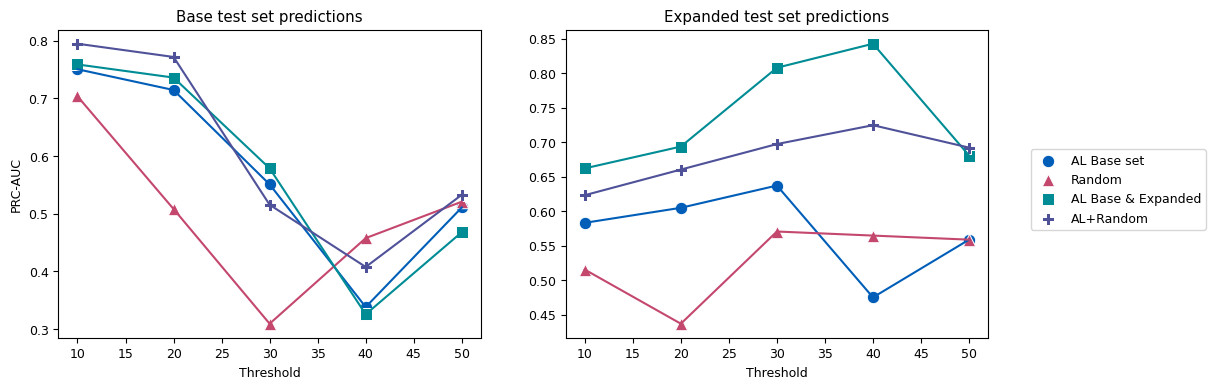

In [58]:

# plot f1 and prc-auc by yield threshold for both test sets
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)

# each plot is really the data from 5 columns of a single row

sns.lineplot(data=df_core1Tprc, x="Threshold", y="AL Base set", legend=False)
sns.lineplot(data=df_core1Tprc, x="Threshold", y="Random", legend=False)
sns.lineplot(data=df_core1Tprc, x="Threshold", y="AL Base & Expanded", legend=False)
sns.lineplot(data=df_core1Tprc, x="Threshold", y="AL+Random", legend=False)
sns.scatterplot(data=df_core1Tprc, x="Threshold", y="AL Base set", label="AL Base set", marker="o", legend=False, s=80)
sns.scatterplot(data=df_core1Tprc, x="Threshold", y="Random", label="Random", marker="^", legend=False, s=80)
sns.scatterplot(data=df_core1Tprc, x="Threshold", y="AL Base & Expanded", label="AL Base & Expanded", marker="s", legend=False, s=80)
sns.scatterplot(data=df_core1Tprc, x="Threshold", y="AL+Random", label="AL+Random", marker="P", legend=False, s=80)
plt.title(f"Base test set predictions")
plt.ylabel(f"PRC-AUC")

plt.subplot(1, 2, 2)
sns.lineplot(data=df_core2Tprc, x="Threshold", y="AL Base set", legend=False)
sns.lineplot(data=df_core2Tprc, x="Threshold", y="Random", legend=False)
sns.lineplot(data=df_core2Tprc, x="Threshold", y="AL Base & Expanded", legend=False)
sns.lineplot(data=df_core2Tprc, x="Threshold", y="AL+Random", legend=False)
sns.scatterplot(data=df_core2Tprc, x="Threshold", y="AL Base set", label="AL Base set", marker="o", legend=False, s=80)
sns.scatterplot(data=df_core2Tprc, x="Threshold", y="Random", label="Random", marker="^", legend=False, s=80)
sns.scatterplot(data=df_core2Tprc, x="Threshold", y="AL Base & Expanded", label="AL Base & Expanded", marker="s", legend=False, s=80)
sns.scatterplot(data=df_core2Tprc, x="Threshold", y="AL+Random", label="AL+Random", marker="P", legend=False, s=80)
#plt.xlabel("Number of reactions")
plt.ylabel('')
plt.legend(loc=(1.1, 0.35))
plt.title("Expanded test set predictions")
plt.show()

In [59]:
dfd1Tf1_cat = pd.concat(dfd1Tf1.values())
dfd2Tf1_cat = pd.concat(dfd2Tf1.values())

In [60]:
df_core1T["features"] = "DFT+DRFP"
df_core2T["features"] = "DFT+DRFP"
dfd1Tf1_cat = pd.concat([dfd1Tf1_cat, df_core1T])
dfd2Tf1_cat = pd.concat([dfd2Tf1_cat, df_core2T])

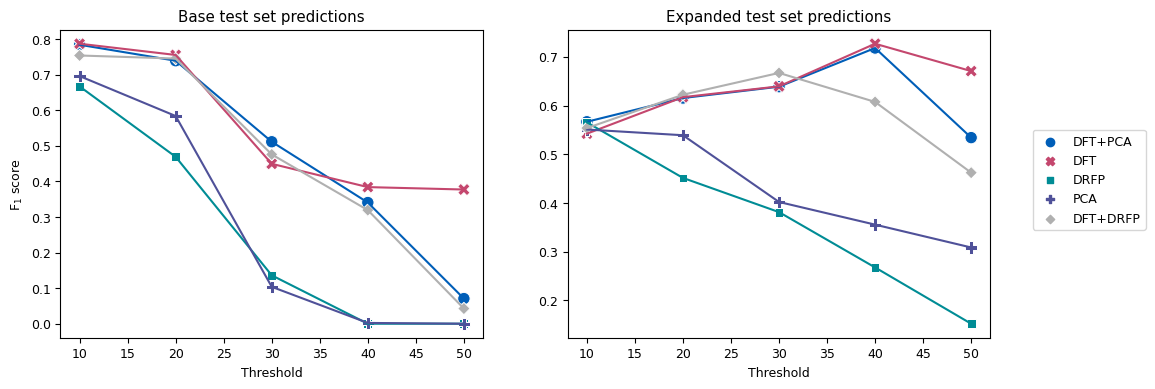

In [61]:
# plot f1 of various feature sets (using AL+Random and AL cores 1)
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)

sns.lineplot(data=dfd1Tf1_cat, x="Threshold", y="AL+Random", hue="features", legend=False)
sns.scatterplot(data=dfd1Tf1_cat, x="Threshold", y="AL+Random", style="features", hue="features", legend=False, s=80)
plt.title(f"Base test set predictions")
plt.ylabel(f"F$_1$ score")

plt.subplot(1, 2, 2)
sns.lineplot(data=dfd2Tf1_cat, x="Threshold", y="AL+Random", hue="features", legend=False)
sns.scatterplot(data=dfd2Tf1_cat, x="Threshold", y="AL+Random", hue="features", style="features", s=80)
#plt.xlabel("Number of reactions")
plt.ylabel('')
plt.legend(loc=(1.1, 0.35))
plt.title("Expanded test set predictions")
plt.show()

In [67]:
dfd1_cat = pd.concat(dfd1.values())
dfd2_cat = pd.concat(dfd2.values())
dfd1_cat

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,features
AL+Random,0.512311,7.575443,11.758499,11.695714,0.863005,0.9596,0.784028,0.662816,0.816441,0.881140,...,0.287059,0.340610,0.431999,0.390928,0.960104,0.0400,0.070667,0.310000,0.534896,DFT+PCA
AL cores 1,0.406360,8.041522,12.970821,12.102411,0.864041,0.9500,0.783542,0.666786,0.814870,0.857513,...,0.182353,0.221675,0.304843,0.279608,0.956995,0.0025,0.004444,0.020000,0.391924,DFT+PCA
AL cores 1&2,0.390902,8.432017,13.137281,12.707079,0.861347,0.9488,0.780013,0.662334,0.812199,0.844663,...,0.249412,0.276625,0.322084,0.318805,0.953782,0.0200,0.028274,0.070000,0.245311,DFT+PCA
Random,0.219080,8.355518,14.880028,7.323993,0.864456,0.7616,0.744089,0.728370,0.775866,0.815855,...,0.018824,0.030163,0.078333,0.091791,0.953782,0.0000,0.000000,0.000000,0.070725,DFT+PCA
AL+Random,0.490300,7.590754,12.019180,12.271235,0.865389,0.9596,0.786981,0.667034,0.818550,0.883316,...,0.365882,0.383980,0.407306,0.414522,0.961969,0.2750,0.377191,0.669159,0.487105,DFT
AL cores 1,0.354604,8.236296,13.524807,12.787802,0.858135,0.9356,0.773630,0.659518,0.805901,0.863523,...,0.324706,0.324488,0.332890,0.358539,0.954611,0.0500,0.076199,0.191667,0.230522,DFT
AL cores 1&2,0.310108,8.804647,13.982748,14.000534,0.856062,0.9380,0.771544,0.655307,0.804684,0.854819,...,0.457647,0.388250,0.339587,0.422503,0.953575,0.1875,0.241816,0.363714,0.302447,DFT
Random,0.219762,8.442303,14.873394,7.737604,0.852124,0.7576,0.726061,0.697741,0.759069,0.827772,...,0.009412,0.014561,0.032667,0.064666,0.947461,0.0000,0.000000,0.000000,0.020725,DFT
AL+Random,0.302999,9.761180,14.058222,9.965845,0.796373,0.7844,0.666996,0.581110,0.710683,0.819378,...,0.000000,0.000000,0.000000,0.044041,0.955337,0.0000,0.000000,0.000000,0.210725,DRFP
AL cores 1,0.340446,9.402383,13.675490,11.057030,0.793472,0.8056,0.669230,0.572590,0.714276,0.837098,...,0.001176,0.002105,0.010000,0.049578,0.957617,0.0000,0.000000,0.000000,0.430725,DRFP


In [68]:
dfd1_cat.index.name = "Dataset"
dfd1_cat.reset_index(inplace=True)
dfd2_cat.index.name = "Dataset"
dfd2_cat.reset_index(inplace=True)

dfd1Tf1_cat.index.name = "Dataset"
dfd1Tf1_cat.reset_index(inplace=True)
dfd2Tf1_cat.index.name = "Dataset"
dfd2Tf1_cat.reset_index(inplace=True)
dfd1Tf1_cat

,Dataset,AL+Random,AL cores 1,AL cores 1&2,Random,Threshold,features,AL Base set,AL Base & Expanded
0,0,0.784028,0.783542,0.780013,0.744089,10,DFT+PCA,NaN,NaN
1,1,0.739170,0.696866,0.683580,0.366460,20,DFT+PCA,NaN,NaN
2,2,0.511441,0.508738,0.515731,0.122855,30,DFT+PCA,NaN,NaN
3,3,0.340610,0.221675,0.276625,0.030163,40,DFT+PCA,NaN,NaN
4,4,0.070667,0.004444,0.028274,0.000000,50,DFT+PCA,NaN,NaN
5,5,0.786981,0.773630,0.771544,0.726061,10,DFT,NaN,NaN
6,6,0.755390,0.718747,0.719138,0.443249,20,DFT,NaN,NaN
7,7,0.449420,0.490564,0.471195,0.112749,30,DFT,NaN,NaN
8,8,0.383980,0.324488,0.388250,0.014561,40,DFT,NaN,NaN
9,9,0.377191,0.076199,0.241816,0.000000,50,DFT,NaN,NaN


In [69]:
dfd1Tf1_cat.drop(columns="Dataset", inplace=True)
dfd2Tf1_cat.drop(columns="Dataset", inplace=True)

In [70]:
dfd1_cat.to_csv("figure_data/replicate_model_performance_core1_features.csv", index=False)
dfd2_cat.to_csv("figure_data/replicate_model_performance_core2_features.csv", index=False)

In [13]:
dfd1_cat = pd.read_csv("figure_data/replicate_model_performance_core1_features.csv")
dfd2_cat = pd.read_csv("figure_data/replicate_model_performance_core2_features.csv")

In [14]:
df_core1

,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,20_acc,...,40_acc,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc
AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,0.892746,...,0.910984,0.240000,0.319293,0.508395,0.407669,0.959585,0.0250,0.042667,0.160000,0.532707
AL Base set,0.364073,8.272119,13.425702,11.467187,0.824456,0.8400,0.712662,0.618933,0.750192,0.855544,...,0.906321,0.168235,0.236153,0.435029,0.338264,0.958446,0.0000,0.000000,0.000000,0.510725
AL Base & Expanded,0.422178,8.431127,12.798881,11.953000,0.834715,0.8352,0.723876,0.639126,0.758510,0.865803,...,0.899793,0.197647,0.256330,0.382981,0.325651,0.958860,0.0325,0.053939,0.183333,0.467968
Random,0.165672,8.527050,15.380590,5.987977,0.830984,0.5872,0.642551,0.712448,0.703295,0.809326,...,0.914197,0.051765,0.095205,0.660000,0.457644,0.958549,0.0000,0.000000,0.000000,0.520725


In [15]:
df_core1["features"] = "DFT+DRFP"
df_core1.index.name = "Dataset"
df_core1.reset_index(inplace=True)
df_core2["features"] = "DFT+DRFP"
df_core2.index.name = "Dataset"
df_core2.reset_index(inplace=True)
df_core1


,Dataset,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,features
0,AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,...,0.240000,0.319293,0.508395,0.407669,0.959585,0.0250,0.042667,0.160000,0.532707,DFT+DRFP
1,AL Base set,0.364073,8.272119,13.425702,11.467187,0.824456,0.8400,0.712662,0.618933,0.750192,...,0.168235,0.236153,0.435029,0.338264,0.958446,0.0000,0.000000,0.000000,0.510725,DFT+DRFP
2,AL Base & Expanded,0.422178,8.431127,12.798881,11.953000,0.834715,0.8352,0.723876,0.639126,0.758510,...,0.197647,0.256330,0.382981,0.325651,0.958860,0.0325,0.053939,0.183333,0.467968,DFT+DRFP
3,Random,0.165672,8.527050,15.380590,5.987977,0.830984,0.5872,0.642551,0.712448,0.703295,...,0.051765,0.095205,0.660000,0.457644,0.958549,0.0000,0.000000,0.000000,0.520725,DFT+DRFP


In [16]:
dfd1_cat = pd.concat([dfd1_cat, df_core1])
dfd2_cat = pd.concat([dfd2_cat, df_core2])
dfd1_cat

,Dataset,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,features
0,AL+Random,0.512311,7.575443,11.758499,11.695714,0.863005,0.9596,0.784028,0.662816,0.816441,...,0.287059,0.340610,0.431999,0.390928,0.960104,0.0400,0.070667,0.310000,0.534896,DFT+PCA
1,AL cores 1,0.406360,8.041522,12.970821,12.102411,0.864041,0.9500,0.783542,0.666786,0.814870,...,0.182353,0.221675,0.304843,0.279608,0.956995,0.0025,0.004444,0.020000,0.391924,DFT+PCA
2,AL cores 1&2,0.390902,8.432017,13.137281,12.707079,0.861347,0.9488,0.780013,0.662334,0.812199,...,0.249412,0.276625,0.322084,0.318805,0.953782,0.0200,0.028274,0.070000,0.245311,DFT+PCA
3,Random,0.219080,8.355518,14.880028,7.323993,0.864456,0.7616,0.744089,0.728370,0.775866,...,0.018824,0.030163,0.078333,0.091791,0.953782,0.0000,0.000000,0.000000,0.070725,DFT+PCA
4,AL+Random,0.490300,7.590754,12.019180,12.271235,0.865389,0.9596,0.786981,0.667034,0.818550,...,0.365882,0.383980,0.407306,0.414522,0.961969,0.2750,0.377191,0.669159,0.487105,DFT
5,AL cores 1,0.354604,8.236296,13.524807,12.787802,0.858135,0.9356,0.773630,0.659518,0.805901,...,0.324706,0.324488,0.332890,0.358539,0.954611,0.0500,0.076199,0.191667,0.230522,DFT
6,AL cores 1&2,0.310108,8.804647,13.982748,14.000534,0.856062,0.9380,0.771544,0.655307,0.804684,...,0.457647,0.388250,0.339587,0.422503,0.953575,0.1875,0.241816,0.363714,0.302447,DFT
7,Random,0.219762,8.442303,14.873394,7.737604,0.852124,0.7576,0.726061,0.697741,0.759069,...,0.009412,0.014561,0.032667,0.064666,0.947461,0.0000,0.000000,0.000000,0.020725,DFT
8,AL+Random,0.302999,9.761180,14.058222,9.965845,0.796373,0.7844,0.666996,0.581110,0.710683,...,0.000000,0.000000,0.000000,0.044041,0.955337,0.0000,0.000000,0.000000,0.210725,DRFP
9,AL cores 1,0.340446,9.402383,13.675490,11.057030,0.793472,0.8056,0.669230,0.572590,0.714276,...,0.001176,0.002105,0.010000,0.049578,0.957617,0.0000,0.000000,0.000000,0.430725,DRFP


In [17]:
dfd1_all = dfd1_cat[dfd1_cat["Dataset"] == "AL+Random"]
dfd2_all = dfd2_cat[dfd2_cat["Dataset"] == "AL+Random"]
dfd1_all

,Dataset,r2,mae,rmse,mean,10_acc,10_recall,10_f1,10_precision,10_prc-auc,...,40_recall,40_f1,40_precision,40_prc-auc,50_acc,50_recall,50_f1,50_precision,50_prc-auc,features
0,AL+Random,0.512311,7.575443,11.758499,11.695714,0.863005,0.9596,0.784028,0.662816,0.816441,...,0.287059,0.340610,0.431999,0.390928,0.960104,0.040,0.070667,0.310000,0.534896,DFT+PCA
4,AL+Random,0.490300,7.590754,12.019180,12.271235,0.865389,0.9596,0.786981,0.667034,0.818550,...,0.365882,0.383980,0.407306,0.414522,0.961969,0.275,0.377191,0.669159,0.487105,DFT
8,AL+Random,0.302999,9.761180,14.058222,9.965845,0.796373,0.7844,0.666996,0.581110,0.710683,...,0.000000,0.000000,0.000000,0.044041,0.955337,0.000,0.000000,0.000000,0.210725,DRFP
12,AL+Random,0.319432,9.277221,13.891232,10.660613,0.802591,0.8720,0.696025,0.579304,0.742232,...,0.001176,0.002222,0.020000,0.474578,0.958549,0.000,0.000000,0.000000,0.520725,PCA
0,AL+Random,0.515693,7.928584,11.716920,11.397120,0.838756,0.9516,0.753904,0.624704,0.794422,...,0.240000,0.319293,0.508395,0.407669,0.959585,0.025,0.042667,0.160000,0.532707,DFT+DRFP


In [18]:
dfd1T = dfd1_all.set_index("features").T.loc[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]]
dfd2T = dfd2_all.set_index("features").T.loc[["10_f1", "20_f1", "30_f1", "40_f1", "50_f1"]]
dfd1T

features,DFT+PCA,DFT,DRFP,PCA,DFT+DRFP
10_f1,0.784028,0.786981,0.666996,0.696025,0.753904
20_f1,0.73917,0.75539,0.469057,0.583795,0.745266
30_f1,0.511441,0.44942,0.136043,0.103706,0.475796
40_f1,0.34061,0.38398,0.0,0.002222,0.319293
50_f1,0.070667,0.377191,0.0,0.0,0.042667


In [19]:
dfd1T["Threshold"] = [10,20,30,40,50]
dfd2T["Threshold"] = [10,20,30,40,50]
dfd1T

features,DFT+PCA,DFT,DRFP,PCA,DFT+DRFP,Threshold
10_f1,0.784028,0.786981,0.666996,0.696025,0.753904,10
20_f1,0.73917,0.75539,0.469057,0.583795,0.745266,20
30_f1,0.511441,0.44942,0.136043,0.103706,0.475796,30
40_f1,0.34061,0.38398,0.0,0.002222,0.319293,40
50_f1,0.070667,0.377191,0.0,0.0,0.042667,50


In [20]:
def reshape_data(df, features):
    dfs = []
    for f in features:
        ds = df[[f, "Threshold"]]
        ds.rename(columns={f:"f1"}, inplace=True)
        ds["feature"] = f
        dfs.append(ds)
    return pd.concat(dfs)

features = ["DFT", "DRFP", "PCA", "DFT+DRFP", "DFT+PCA"]
dfd1Tf1_cat = reshape_data(dfd1T, features)
dfd2Tf1_cat = reshape_data(dfd2T, features)
dfd1Tf1_cat

/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/rickena1/modules/brbr_actlearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


features,f1,Threshold,feature
10_f1,0.786981,10,DFT
20_f1,0.75539,20,DFT
30_f1,0.44942,30,DFT
40_f1,0.38398,40,DFT
50_f1,0.377191,50,DFT
10_f1,0.666996,10,DRFP
20_f1,0.469057,20,DRFP
30_f1,0.136043,30,DRFP
40_f1,0.0,40,DRFP
50_f1,0.0,50,DRFP


In [21]:
plt.rcParams.update({"font.size":9})

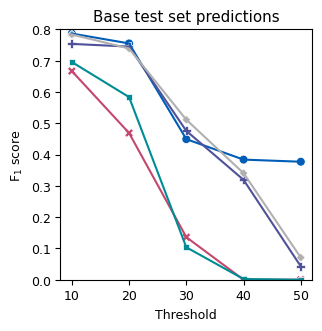

In [22]:
lims = [-0.0,0.8]
# plot f1 of various feature sets (using f1 and AL cores 1)
plt.figure(figsize=(3.25, 3.25))

sns.lineplot(data=dfd1Tf1_cat, x="Threshold", y="f1", hue="feature", legend=False, palette=custom_palette)
sns.scatterplot(data=dfd1Tf1_cat, x="Threshold", y="f1", style="feature", legend=False, hue="feature", s=40, palette=custom_palette)
plt.title(f"Base test set predictions")
plt.ylabel(f"F$_1$ score")
plt.ylim(lims)
#plt.legend()
plt.show()
#plt.savefig("images/hyperopt_f1_core1_features.png", dpi=300, bbox_inches="tight")

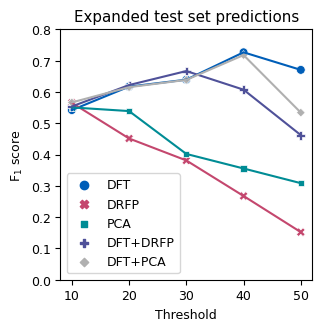

In [23]:
plt.figure(figsize=(3.25, 3.25))
sns.lineplot(data=dfd2Tf1_cat, x="Threshold", y="f1", hue="feature", legend=False, palette=custom_palette)
#sns.scatterplot(data=dfd2Tf1_cat, x="Threshold", y="f1", hue="feature", legend=False, style="feature", s=40, palette=custom_palette)
sns.scatterplot(data=dfd2Tf1_cat, x="Threshold", y="f1", hue="feature", style="feature", s=40, palette=custom_palette)
#plt.xlabel("Number of reactions")
plt.ylabel(f"F$_1$ score")
plt.ylim(lims)
plt.title("Expanded test set predictions")
plt.legend()
plt.show()
#plt.savefig("images/hyperopt_f1_core2_features.png", dpi=300, bbox_inches="tight")

In [25]:
dfd1Tf1_cat.to_csv("figure_data/hyperopt_features_f1_core1Tf1_cat.csv")
dfd2Tf1_cat.to_csv("figure_data/hyperopt_features_f1_core2Tf1_cat.csv")